In [1]:
import json

# Load the first and second JSON files
with open(r'C:\Users\leonc\Thesis 2024\Toxic-Symbology\Text Clustering\ontoxGPAHE.json', 'r') as f1, open(r'C:\Users\leonc\Thesis 2024\Toxic-Symbology\tools\OnToxMeme_dict.json', 'r') as f2:
    data1 = json.load(f1)
    data2 = json.load(f2)

# Extract keys from the second file that have "Referenced_in_meme"
keys_with_references = {
    key for key, value in data2.items() if "Referenced_in_meme" in value
}

# Filter entries from the first file based on these keys
filtered_entries = {
    key: value for key, value in data1.items() if key in keys_with_references
}

# Save the filtered entries to a new JSON file
with open('ontoxGPAHE_56.json', 'w') as output:
    json.dump(filtered_entries, output, indent=4)

In [2]:
import pickle
from bertopic import BERTopic

with open(r'C:\Users\leonc\Thesis 2024\Toxic-Symbology\Text Clustering\ontoxGPAHE_56.json', 'r') as f:
    data = json.load(f)

descriptions_1 = [entry["Description"] for entry in data.values()]
descriptions_2 = [entry["Description"] + entry["Title"] for entry in data.values()]
descriptions_3 = [entry["Description"] + entry["Title"] + entry["Ideology"] for entry in data.values()]

In [3]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings_1 = model.encode(descriptions_1, show_progress_bar=True)

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings_2 = model.encode(descriptions_1, show_progress_bar=True)

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings_3 = model.encode(descriptions_1, show_progress_bar=True)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
import umap
import pandas as pd

umap_embeddings_1 = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings_1)

umap_embeddings_2 = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings_2)

umap_embeddings_3 = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings_3)

In [5]:
import hdbscan

cluster_1 = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings_1)

cluster_2 = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings_2)

cluster_3 = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings_3)

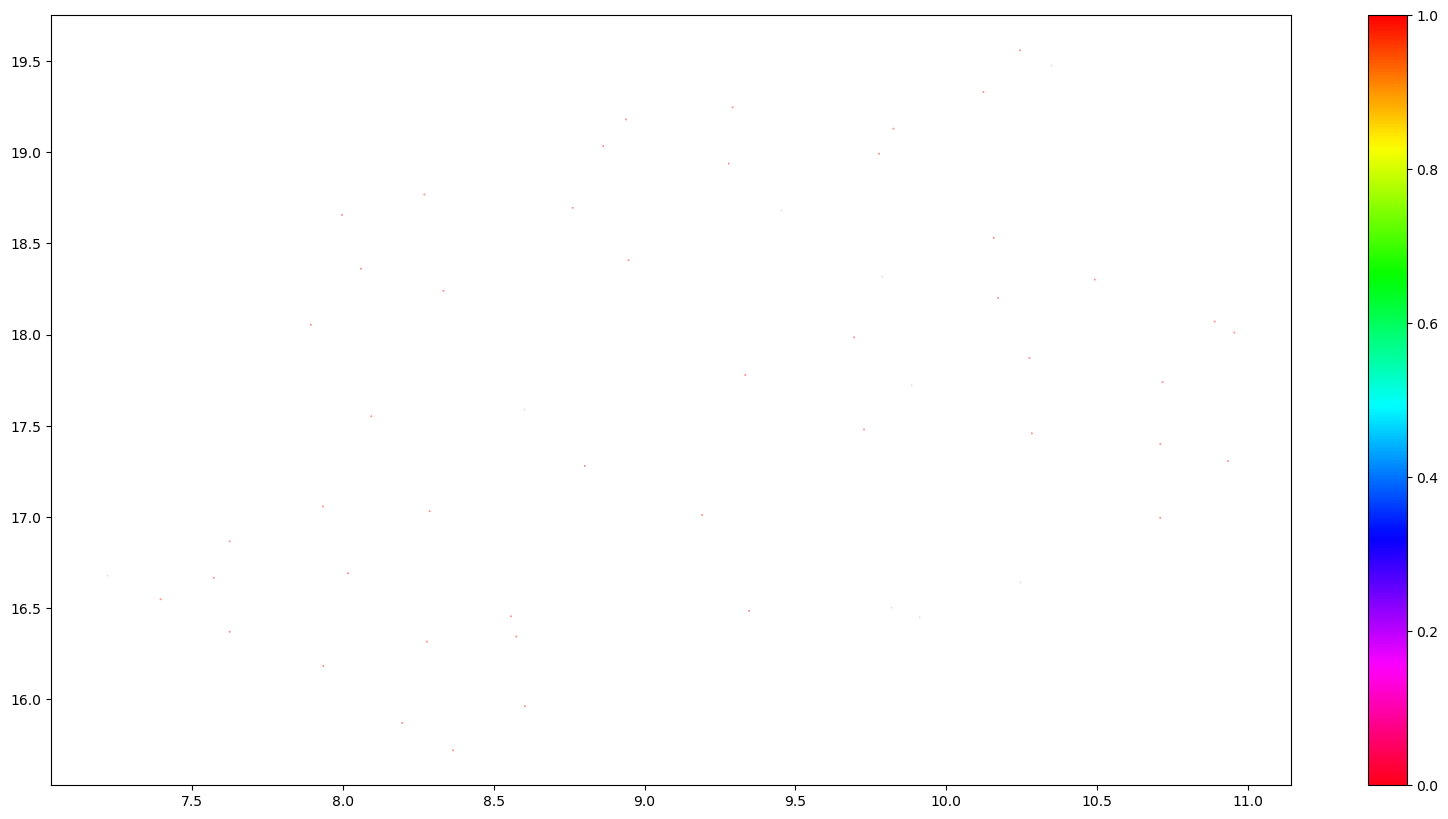

In [6]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings_1)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster_1.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

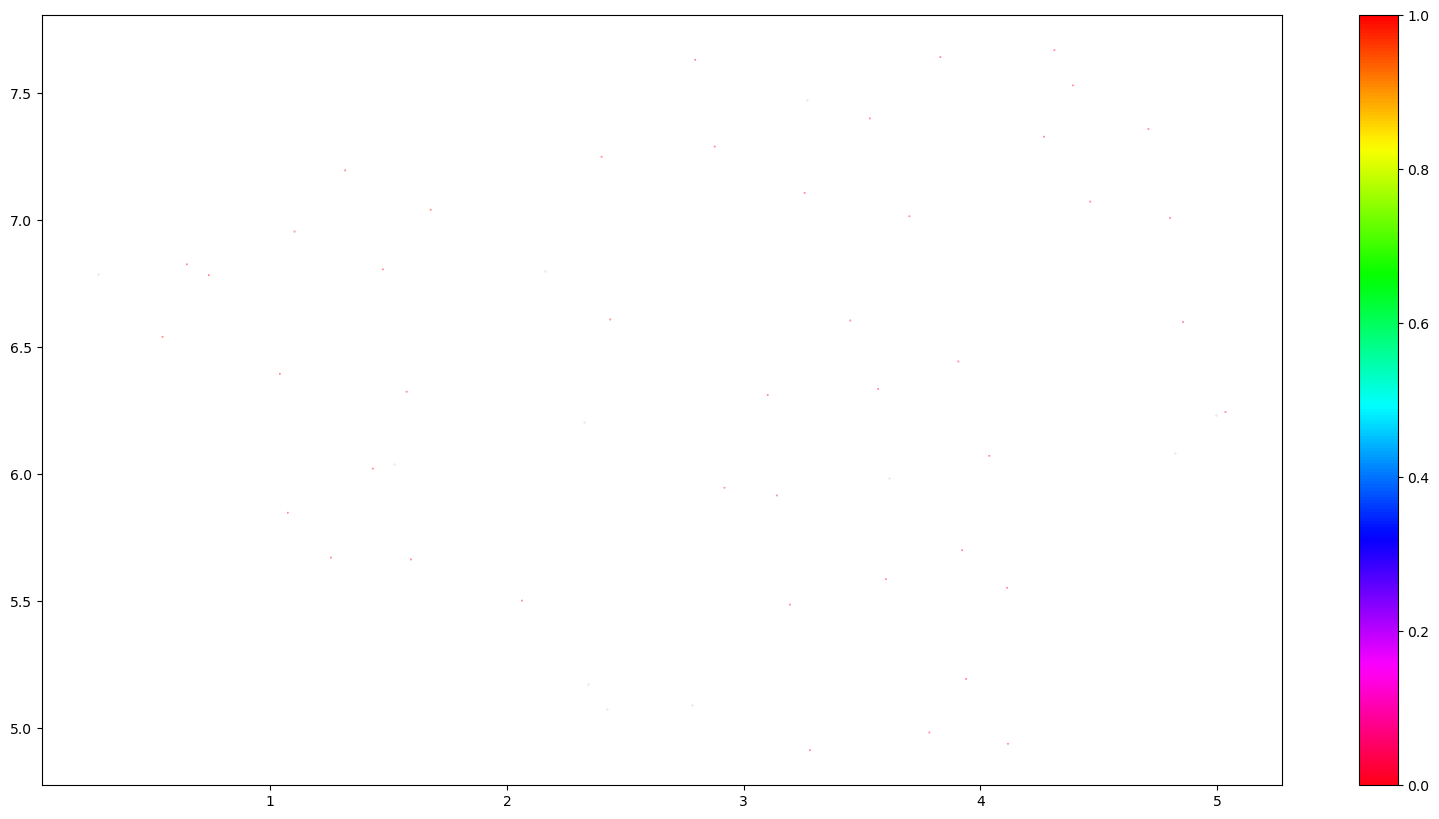

In [7]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings_2)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster_2.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

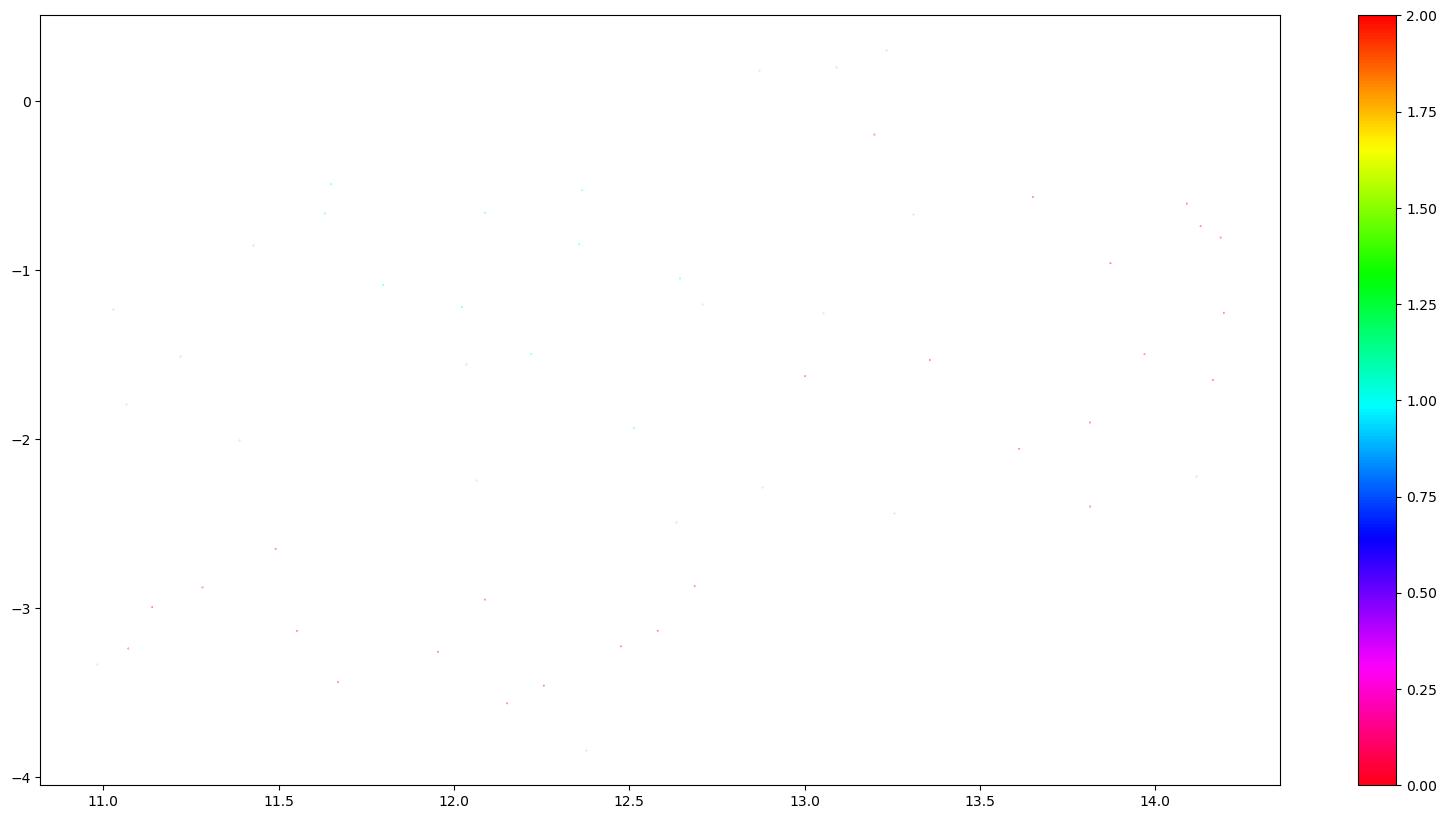

In [8]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings_3)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster_3.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [9]:
docs_df_1 = pd.DataFrame(descriptions_1, columns=["Doc"])
docs_df_1['Topic'] = cluster_1.labels_
docs_df_1['Doc_ID'] = range(len(docs_df_1))
docs_per_topic_1 = docs_df_1.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

docs_df_2 = pd.DataFrame(descriptions_2, columns=["Doc"])
docs_df_2['Topic'] = cluster_2.labels_
docs_df_2['Doc_ID'] = range(len(docs_df_2))
docs_per_topic_2 = docs_df_2.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

docs_df_3 = pd.DataFrame(descriptions_3, columns=["Doc"])
docs_df_3['Topic'] = cluster_3.labels_
docs_df_3['Doc_ID'] = range(len(docs_df_3))
docs_per_topic_3 = docs_df_3.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [10]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf_1, count_1 = c_tf_idf(docs_per_topic_1.Doc.values, m=len(data))
tf_idf_2, count_2 = c_tf_idf(docs_per_topic_2.Doc.values, m=len(data))
tf_idf_3, count_3 = c_tf_idf(docs_per_topic_3.Doc.values, m=len(data))

In [11]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words_1 = extract_top_n_words_per_topic(tf_idf_1, count_1, docs_per_topic_1, n=20)
topic_sizes_1 = extract_topic_sizes(docs_df_1); topic_sizes_1.head(10)

top_n_words_2 = extract_top_n_words_per_topic(tf_idf_2, count_2, docs_per_topic_2, n=20)
topic_sizes_2 = extract_topic_sizes(docs_df_2); topic_sizes_2.head(10)

top_n_words_3 = extract_top_n_words_per_topic(tf_idf_3, count_3, docs_per_topic_3, n=20)
topic_sizes_3 = extract_topic_sizes(docs_df_3); topic_sizes_3.head(10)

,Topic,Size
0,-1,19
3,2,14
1,0,13
2,1,10


In [12]:
# Add symbols to docs_df
symbols = [entry["Title"] for entry in data.values()]  # Extract symbols from your dataset
docs_df_1['Toxic Symbol'] = symbols

symbols = [entry["Title"] for entry in data.values()]  # Extract symbols from your dataset
docs_df_2['Toxic Symbol'] = symbols

symbols = [entry["Title"] for entry in data.values()]  # Extract symbols from your dataset
docs_df_3['Toxic Symbol'] = symbols

In [13]:
docs_df_1_sorted = docs_df_1.sort_values(by='Topic', ascending=True).reset_index(drop=True)
docs_df_1_sorted.to_csv('description.csv', index=False)

docs_df_2_sorted = docs_df_2.sort_values(by='Topic', ascending=True).reset_index(drop=True)
docs_df_2_sorted.to_csv('description_title.csv', index=False)

docs_df_3_sorted = docs_df_3.sort_values(by='Topic', ascending=True).reset_index(drop=True)
docs_df_3_sorted.to_csv('description_title_ideology.csv', index=False)

In [14]:
# Load the CSV file into a DataFrame
docs_df_1_sorted = pd.read_csv(r'C:\Users\leonc\Thesis 2024\Toxic-Symbology\Text Clustering\description.csv')

In [15]:
# Load the CSV file into a DataFrame
docs_df_2_sorted = pd.read_csv(r'C:\Users\leonc\Thesis 2024\Toxic-Symbology\Text Clustering\description_title.csv')

In [16]:
# Load the CSV file into a DataFrame
docs_df_3_sorted = pd.read_csv(r'C:\Users\leonc\Thesis 2024\Toxic-Symbology\Text Clustering\description_title_ideology.csv')

In [17]:
docs_df_1_sorted

,Doc,Topic,Doc_ID,Toxic Symbol
0,"ZOG is shorthand for ""Zionist Occupied Governm...",-1,55,ZOG
1,"""You will own nothing and be happy"" is a phras...",-1,52,You will own nothing and be happy
2,"""Grand Remplacement"" (""Great Replacement"") (al...",-1,23,Grand Remplacement / être grand remplacé (Grea...
3,"""White Power"" is a white nationalist slogan or...",-1,50,"White Power (also ""WP"")"
4,"The phrase “White Lives Matter"" is sometimes s...",-1,49,White Lives Matter
5,The Antifa Helicopter Ride meme is an explicit...,-1,8,Antifa Helicopter Ride meme
6,"""Total\n \n\n\n\n\n ...",-1,45,Total _____ Death (T_D)
7,"The echo symbol, which is a set of parentheses...",-1,19,Echo ((( )))
8,Cultural Marxism is a far-right conspiracy tha...,-1,15,Cultural Marxism
9,The flag of the fake country of Kekistan is a ...,0,29,Kekistan Flag


In [18]:
docs_df_2_sorted

,Doc,Topic,Doc_ID,Toxic Symbol
0,"ZOG is shorthand for ""Zionist Occupied Governm...",-1,55,ZOG
1,"""Grand Remplacement"" (""Great Replacement"") (al...",-1,23,Grand Remplacement / être grand remplacé (Grea...
2,"Right Wind Death Squad, usually shortened to R...",-1,38,Right Wing Death Squad (RWDS)
3,Cultural Marxism is a far-right conspiracy tha...,-1,15,Cultural Marxism
4,"Reference to ""Clown World"" or the emoticons of...",-1,12,Clown World
5,Agenda 21 is a non-binding action plan establi...,-1,6,Agenda 21
6,"The ""Groyper"" is a large green toad with his f...",-1,43,The Groyper
7,YWNBAW (You Will Never Be A Woman) is an anti-...,-1,53,YWNBAW (You Will Never Be A Woman)
8,"""You will own nothing and be happy"" is a phras...",-1,52,You will own nothing and be happy
9,"""White Power"" is a white nationalist slogan or...",-1,50,"White Power (also ""WP"")"


In [19]:
docs_df_3_sorted

,Doc,Topic,Doc_ID,Toxic Symbol
0,"ZOG is shorthand for ""Zionist Occupied Governm...",-1,55,ZOG
1,"""I will not eat the bugs"" is a phrase original...",-1,26,I will not eat the bugs
2,"The echo symbol, which is a set of parentheses...",-1,19,Echo ((( )))
3,"Right Wind Death Squad, usually shortened to R...",-1,38,Right Wing Death Squad (RWDS)
4,Cultural Marxism is a far-right conspiracy tha...,-1,15,Cultural Marxism
5,"""The Goyim Know"" is a slogan that impersonates...",-1,42,The Goyim Know
6,"The ""Groyper"" is a large green toad with his f...",-1,43,The Groyper
7,"Reference to ""Clown World"" or the emoticons of...",-1,12,Clown World
8,"""Total\n \n\n\n\n\n ...",-1,45,Total _____ Death (T_D)
9,"""Grand Remplacement"" (""Great Replacement"") (al...",-1,23,Grand Remplacement / être grand remplacé (Grea...
